In [6]:
%load_ext  autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('..')

In [8]:
import os
import math

import numpy as np
import pandas as pd
import seaborn as sns
from itertools import groupby
from IPython.display import display, HTML

from trickster.search import a_star_search
from trickster.wfp_helper import extract, load_cell, onehot, pad_and_onehot, reverse_onehot

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from scipy.spatial import distance
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from defaultcontext import with_default_context
from profiled import Profiler, profiled

seed = 2018

In [9]:
def load_data(path='./data/wfp_traces/'):
    labels = []
    data = []
    for fn in tqdm_notebook(os.listdir(path)):
        file_path = path + fn
        if os.path.isfile(file_path):
            cell_list = load_cell(file_path)
            if "-" in str(fn):
                labels.append(1)
                data.append(cell_list)
            else:
                labels.append(0)
                data.append(cell_list)
        
    labels = np.array(labels)
    data = np.array(data)
    return data, labels

# Load data

Load website cell traces - load both cell traces and CUMUL features for classification.

In [27]:
X, y = load_data(path='./data/wfp_traces_toy/')
X, y = X[:500], y[:500]

trace_len, X = pad_and_onehot(X)
print("Shape of data: {}, Shape of labels: {}".format(X.shape, y.shape))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
print(X_test.shape)
print("Number train samples: {}, Number test samples: {}".format(X_train.shape[0], X_test.shape[0]))


Shape of data: (96, 2847), Shape of labels: (96,)
(10, 2847)
Number train samples: 86, Number test samples: 10


# Fit logistic regression model

In [28]:
# Fit logistic regression
clf = LogisticRegression(
    random_state=seed
)
clf.fit(X_train, y_train)

print('Test score is: {:.2f}%.'.format(clf.score(X_test, y_test)*100))

Test score is: 100.00%.


In [29]:
@with_default_context(use_empty_init=True)
class Counter:
    def __init__(self):
        self.cnt = 0
        
    def increment(self):
        self.cnt += 1
        
    def count(self):
        return self.cnt

Define `Node` class transformation code:   
`weight_beginning` and `weight_bursts` decide to prioritise the start of a trace and large bursts, respectively, when choosing where to insert a new request.  
`children_num` spawns a number of children.  
`pad_requests` inserts a number of consecutive requests at a chosen index.

In [30]:
class Node:
    
    def __init__(self, x, weight_beginning=True, weight_bursts=True, children_num=1, pad_requests=3):
        self.root = list(reverse_onehot(x, trace_len))
        self.weight_beginning = weight_beginning
        self.weight_bursts = weight_bursts
        self.children_num = children_num 
        self.pad_requests = pad_requests 

    def _get_burst_arr(self, x):
        """Get an array of all bursts in cell trace.
           Return array with rows [idx0, idx1, len]
           idx0 : index of start of burst
           idx1 : index of end of burst
           len : length of burst
        """
        iszero = np.concatenate(([0], np.equal(x, -1).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        ranges_size = np.array([(x[0], x[1], x[1]-x[0]) for x in ranges])
        return ranges_size
    
    def _get_random_burst(self, bursts):
       
        if self.weight_beginning and not self.weight_bursts:
            bursts = bursts[bursts[:,0].argsort()]
            weight_arr = np.linspace(0.01, 0.99, num=bursts.shape[0])[::-1]
            weight_arr /= sum(weight_arr)
            index = np.random.choice(bursts.shape[0], p=weight_arr)
        
        elif not self.weight_beginning and self.weight_bursts:
            bursts = bursts[bursts[:,2].argsort()]
            weight_arr = np.linspace(0.01, 0.99, num=bursts.shape[0])[::-1]
            weight_arr /= sum(weight_arr)
            index = np.random.choice(bursts.shape[0], p=weight_arr)

        elif self.weight_beginning and self.weight_bursts:
            weight_arr = np.array([x[1]/float(x[0])-1 for x in bursts])
            weight_arr /= sum(weight_arr)
            index = np.random.choice(bursts.shape[0], p=weight_arr)

        else:
            index = np.random.randint(bursts.shape[0])
        
        return bursts[index]
    
    def expand(self):
        # Increment the counter of expanded nodes.
        counter = Counter.get_default()
        counter.increment()

        children = [ ]

        for i in range(self.children_num):
            bursts = self._get_burst_arr(self.root)
            burst = self._get_random_burst(bursts)
            new_request_idx = int(burst[0]) + int(burst[2]/ 2)
            expanded_node = self.root[:new_request_idx] + [1]*self.pad_requests + self.root[new_request_idx:]
            children.append(np.array(expanded_node)[:trace_len])
        
        return onehot(children)
    
    def __repr__(self):
        return 'Node({})'.format(self.root)

All the functions that need to be passed into the search, in the expected format.

In [31]:
def _expand_fn(x, p_norm=1, **kwargs):
    """Wrap the example in `Node`, expand the node, and compute the costs.
    
    Returns a list of tuples (child, cost)
    """
    node = Node(x, **kwargs)
    children = node.expand()
    costs = [np.linalg.norm(
        np.array(reverse_onehot(x, trace_len)) - np.array(reverse_onehot(c, trace_len)), ord=p_norm)
             for c in children]
    return list(zip(children, costs))

def _goal_fn(x, clf, target_confidence=0.5):
    """Tell whether the example has reached the goal."""
    return clf.predict_proba([x])[0, 1] >= target_confidence

def _heuristic_fn(x, clf, q_norm=np.inf):
    """Distance to the decision boundary of a logistic regression classifier.
    
    By default the distance is w.r.t. L1 norm. This means that the denominator
    has to be in terms of the Holder dual norm (`q_norm`), so L-inf. I know,
    this interface is horrible.
    
    NOTE: The value has to be zero if the example is already on the target side
    of the boundary.
    """
    score = clf.decision_function([x])[0]
    if score >= 0:
        return 0.0
    return np.abs(score) / np.linalg.norm(clf.coef_, ord=q_norm)

def hash_fn(x):
    """Hash function for examples."""
    x_str = ''.join(str(e) for e in x)
    return hash(x_str)

In [32]:
@profiled
def find_adversarial(x, clf, p_norm=1, q_norm=np.inf,
                     target_confidence=0.5, return_path=False, **kwargs):
    """Transform an example until it is classified with target confidence.""" 

    if clf.predict_proba([x])[0, 1] >= target_confidence:
        raise Exception('Initial example is already classified as positive.')        
    return a_star_search(
        start_node=x, 
        expand_fn=lambda x: _expand_fn(x, p_norm=p_norm, **kwargs), 
        goal_fn=lambda x: _goal_fn(x, clf, target_confidence), 
        heuristic_fn=lambda x: _heuristic_fn(x, clf, q_norm=q_norm), 
        iter_lim=int(1000),
        hash_fn=hash_fn,
        return_path=return_path
    )

In [33]:
def find_adv_examples(X, target_confidence,
                      graph='weight_none', children_num=3, pad_requests=3,
                      p_norm=1, q_norm=np.inf):
    """Find adversarial examples for a whole dataset"""
    
    if graph == 'weight_all':
        node_kwargs = dict(weight_beginning=True, weight_bursts=True, children_num=children_num, pad_requests=pad_requests)
    if graph == 'weight_bursts':
        node_kwargs = dict(weight_beginning=False, weight_bursts=True, children_num=children_num, pad_requests=pad_requests)
    if graph == 'weight_none':
        node_kwargs = dict(weight_beginning=False, weight_bursts=False, children_num=children_num, pad_requests=pad_requests)
 
    # Dataframe for storing the results.
    results = pd.DataFrame(
        columns=['index', 'found', 'confidence', 'original_confidence',
                 'real_cost', 'path_cost', 'nodes_expanded', 'runtime', 'conf_level'])

    # Indices of examples classified as negative.
    neg_indices, = np.where(clf.predict_proba(X)[:, 1] < target_confidence)
    
    for i, original_index in enumerate(neg_indices):
        x = X[original_index]
        
        # Instantiate a counter for expanded nodes, and a profiler.
        expanded_counter = Counter()
        per_example_profiler = Profiler()
        
        with expanded_counter.as_default(), per_example_profiler.as_default():
            x_adv, path_cost = find_adversarial(
                    x, clf, target_confidence=target_confidence, **node_kwargs)

        nodes_expanded = expanded_counter.count()
        runtime = per_example_profiler.compute_stats()['find_adversarial']['tot']
        
        # If an adversarial example was not found, only record index, runtime, and 
        # the number of expanded nodes.
        if x_adv is None:
            results.loc[i] = [original_index, False, [], None,
                              None, None, nodes_expanded, runtime, target_confidence]
        else:
            confidence = clf.predict_proba([x_adv])[0, 1]
            original_confidence = clf.predict_proba([x])[0, 1]
            real_cost = np.linalg.norm(reverse_onehot(x_adv, trace_len), ord=p_norm) - np.linalg.norm(reverse_onehot(x, trace_len), ord=p_norm)
            
            results.loc[i] = [original_index, True, confidence, original_confidence,
                              real_cost, path_cost, nodes_expanded, runtime, target_confidence]

    return results

## Run the experiments  
  
Fix several target confidence levels.

In [34]:
confidence_levels = np.linspace(0.50, 0.95, 10)

Find adversarial examples for the whole dataset using different transformation graphs

In [35]:
results_graph_1 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_1.append(find_adv_examples(X_test, level, graph='weight_all'))

for res in results_graph_1:
    display(HTML(res.to_html()))
    print()
    

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.562257,0.045707,12.0,520.0,16,0.089193,0.5
1,1,True,0.513781,0.006372,18.0,934.0,138,0.686683,0.5
2,2,True,0.562018,0.001607,18.0,1134.0,131,0.640613,0.5
3,5,True,0.500120,0.020312,6.0,482.0,6,0.032372,0.5
4,6,True,0.637077,0.117821,9.0,183.0,4,0.018951,0.5
5,7,True,0.555861,0.014358,27.0,943.0,423,2.076094,0.5
6,8,True,0.643903,0.008303,6.0,818.0,10,0.059029,0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.574066,0.045707,12.0,904.0,115,0.632686,0.55
1,1,True,0.624474,0.006372,21.0,909.0,245,1.250961,0.55
2,2,True,0.637979,0.001607,24.0,1224.0,130,0.695750,0.55
3,5,True,0.633722,0.020312,12.0,720.0,10,0.047914,0.55
4,6,True,0.709547,0.117821,9.0,255.0,3,0.015408,0.55
5,7,True,0.572380,0.014358,24.0,860.0,186,0.882419,0.55
6,8,True,0.798181,0.008303,9.0,865.0,18,0.094667,0.55


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.725072,0.045707,12.0,872.0,116,0.649787,0.6
1,1,True,0.602738,0.006372,21.0,1025.0,288,1.517917,0.6
2,2,True,0.601936,0.001607,24.0,1340.0,321,1.694738,0.6
3,5,True,0.739900,0.020312,12.0,784.0,14,0.074611,0.6
4,6,True,0.795914,0.117821,9.0,267.0,4,0.020935,0.6
5,7,True,0.601204,0.014358,18.0,970.0,109,0.557604,0.6
6,8,True,0.846965,0.008303,9.0,789.0,14,0.082489,0.6


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.709627,0.045707,12.0,836.0,87,0.467286,0.65
1,1,True,0.714417,0.006372,21.0,1033.0,405,2.104735,0.65
2,2,True,0.670776,0.001607,27.0,1511.0,513,2.800690,0.65
3,5,True,0.721773,0.020312,9.0,657.0,11,0.051369,0.65
4,6,True,0.795914,0.117821,9.0,267.0,3,0.013011,0.65
5,7,True,0.689168,0.014358,18.0,726.0,118,0.538433,0.65
6,8,True,0.718694,0.008303,9.0,965.0,20,0.101515,0.65


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.701703,0.045707,12.0,1044.0,218,1.047755,0.7
1,1,True,0.729187,0.006372,24.0,1180.0,608,3.079588,0.7
2,2,True,0.710321,0.001607,30.0,1386.0,393,2.118025,0.7
3,5,True,0.793915,0.020312,12.0,908.0,41,0.219083,0.7
4,6,True,0.740932,0.117821,9.0,219.0,5,0.022102,0.7
5,7,True,0.773787,0.014358,18.0,918.0,305,1.476218,0.7
6,8,True,0.753290,0.008303,9.0,937.0,23,0.126215,0.7


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.759935,0.0457072,21,1125,491,2.556138,0.75
1,1,True,0.75261,0.00637188,24,1184,516,2.577649,0.75
2,2,False,[],None,None,None,1000,5.190237,0.75
3,5,True,0.812296,0.0203119,24,1004,33,0.163248,0.75
4,6,True,0.795914,0.117821,9,267,3,0.017513,0.75
5,7,True,0.779699,0.0143583,18,974,222,1.107301,0.75
6,8,True,0.881199,0.00830272,9,905,19,0.123117,0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.823408,0.0457072,27,1403,674,3.598277,0.8
1,1,True,0.844187,0.00637188,24,1172,486,2.437741,0.8
2,2,False,[],None,None,None,1000,5.171294,0.8
3,5,True,0.836117,0.0203119,15,1091,93,0.456081,0.8
4,6,True,0.853665,0.117821,12,300,8,0.035350,0.8
5,7,True,0.833676,0.0143583,30,1098,753,3.530595,0.8
6,8,True,0.857815,0.00830272,9,937,17,0.083355,0.8


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,5.002411,0.85
1,1,True,0.85413,0.00637188,24,1200,685,3.280458,0.85
2,2,False,[],None,None,None,1000,4.957802,0.85
3,5,True,0.942124,0.0203119,15,899,56,0.267811,0.85
4,6,True,0.863596,0.117821,12,352,8,0.052937,0.85
5,7,False,[],None,None,None,1000,4.732871,0.85
6,8,True,0.852537,0.00830272,12,956,18,0.096000,0.85


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,5.033029,0.9
1,1,False,[],None,None,None,1000,4.935961,0.9
2,2,False,[],None,None,None,1000,5.246419,0.9
3,5,True,0.903404,0.0203119,18,1194,161,0.928474,0.9
4,6,True,0.913145,0.117821,15,365,15,0.084921,0.9
5,7,False,[],None,None,None,1000,5.143452,0.9
6,8,True,0.904876,0.00830272,15,1715,198,1.091301,0.9


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,5.459554,0.95
1,1,False,[],None,None,None,1000,4.928734,0.95
2,2,False,[],None,None,None,1000,5.061099,0.95
3,5,True,0.977939,0.0203119,15,1243,211,1.002953,0.95
4,6,True,0.954877,0.117821,15,457,12,0.050923,0.95
5,7,False,[],None,None,None,1000,4.720008,0.95
6,8,False,[],None,None,None,1000,5.151123,0.95


In [36]:
results_graph_2 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_2.append(find_adv_examples(X_test, level, graph='weight_none'))

for res in results_graph_2:
    display(HTML(res.to_html()))
    print()

,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.607428,0.5
1,1,False,[],None,None,None,1000,4.515389,0.5
2,2,True,0.568866,0.00160745,21,1005,852,3.963325,0.5
3,5,True,0.661103,0.0203119,9,405,11,0.049947,0.5
4,6,True,0.544455,0.117821,12,104,13,0.054466,0.5
5,7,True,0.502202,0.0143583,27,545,351,1.482206,0.5
6,8,True,0.66795,0.00830272,9,661,126,0.555737,0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.714077,0.0457072,12,752,759,3.301461,0.55
1,1,False,[],None,None,None,1000,4.306611,0.55
2,2,False,[],None,None,None,1000,4.388270,0.55
3,5,True,0.599423,0.0203119,15,767,51,0.222564,0.55
4,6,True,0.609509,0.117821,15,129,26,0.103804,0.55
5,7,True,0.563104,0.0143583,21,571,283,1.187364,0.55
6,8,True,0.559997,0.00830272,18,678,133,0.581502,0.55


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.62413,0.0457072,12,736,346,1.490166,0.6
1,1,False,[],None,None,None,1000,4.337004,0.6
2,2,True,0.697409,0.00160745,24,1004,972,4.253121,0.6
3,5,True,0.830416,0.0203119,12,616,31,0.126435,0.6
4,6,True,0.603623,0.117821,12,180,33,0.163305,0.6
5,7,True,0.656531,0.0143583,21,581,696,3.005363,0.6
6,8,True,0.617845,0.00830272,21,717,99,0.438784,0.6


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,True,0.682568,0.0457072,12,816,818,3.539601,0.65
1,1,False,[],None,None,None,1000,4.286156,0.65
2,2,True,0.706647,0.00160745,27,967,322,1.391516,0.65
3,5,True,0.788097,0.0203119,12,500,33,0.136118,0.65
4,6,True,0.758035,0.117821,18,190,31,0.131078,0.65
5,7,True,0.696618,0.0143583,21,725,730,3.170529,0.65
6,8,True,0.695348,0.00830272,9,577,53,0.231854,0.65


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.341418,0.7
1,1,False,[],None,None,None,1000,4.280626,0.7
2,2,False,[],None,None,None,1000,4.336596,0.7
3,5,True,0.703717,0.0203119,24,592,123,0.532018,0.7
4,6,True,0.72198,0.117821,18,190,61,0.276737,0.7
5,7,True,0.744492,0.0143583,18,658,788,3.342453,0.7
6,8,True,0.874982,0.00830272,12,656,167,0.726507,0.7


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.302025,0.75
1,1,False,[],None,None,None,1000,4.270092,0.75
2,2,False,[],None,None,None,1000,4.352482,0.75
3,5,True,0.765276,0.0203119,15,471,25,0.103626,0.75
4,6,True,0.805048,0.117821,21,199,88,0.383704,0.75
5,7,False,[],None,None,None,1000,4.223656,0.75
6,8,True,0.819355,0.00830272,9,701,74,0.326899,0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.365825,0.8
1,1,False,[],None,None,None,1000,4.388698,0.8
2,2,False,[],None,None,None,1000,4.389760,0.8
3,5,True,0.809742,0.0203119,12,600,26,0.120127,0.8
4,6,True,0.800687,0.117821,15,205,58,0.235492,0.8
5,7,True,0.871714,0.0143583,30,638,755,3.219621,0.8
6,8,True,0.927243,0.00830272,12,792,130,0.568367,0.8


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.550457,0.85
1,1,False,[],None,None,None,1000,4.315833,0.85
2,2,False,[],None,None,None,1000,4.321626,0.85
3,5,True,0.875035,0.0203119,21,725,58,0.243789,0.85
4,6,True,0.853671,0.117821,18,246,74,0.292768,0.85
5,7,False,[],None,None,None,1000,4.205617,0.85
6,8,True,0.894984,0.00830272,12,696,104,0.461101,0.85


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.374816,0.9
1,1,False,[],None,None,None,1000,4.386073,0.9
2,2,False,[],None,None,None,1000,4.384817,0.9
3,5,True,0.90755,0.0203119,15,683,155,0.669680,0.9
4,6,True,0.916274,0.117821,15,249,83,0.338810,0.9
5,7,False,[],None,None,None,1000,4.239850,0.9
6,8,False,[],None,None,None,1000,4.452995,0.9


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,0,False,[],None,None,None,1000,4.348143,0.95
1,1,False,[],None,None,None,1000,4.302976,0.95
2,2,False,[],None,None,None,1000,4.357139,0.95
3,5,False,[],None,None,None,1000,4.343104,0.95
4,6,True,0.950293,0.117821,27,305,272,1.131118,0.95
5,7,False,[],None,None,None,1000,4.344415,0.95
6,8,True,0.97695,0.00830272,18,874,319,1.380865,0.95


Check path cost and real cost are correlated.

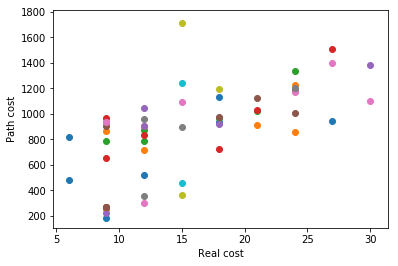

In [37]:
for res in results_graph_1:
    plt.scatter(res['real_cost'], res['path_cost'])
    
plt.xlabel('Real cost')
plt.ylabel('Path cost')
plt.show()

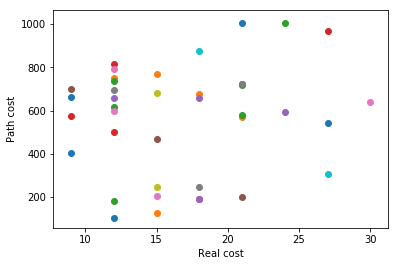

In [38]:
for res in results_graph_2:
    plt.scatter(res['real_cost'], res['path_cost'])
    
plt.xlabel('Real cost')
plt.ylabel('Path cost')
plt.show()

## Sanity check for the optimality

This part was used for debugging. We claim it is more efficient to split larger bursts and insert requests at the beginningof a trace
rather than the end. The assumption is satisfied if the cost adversarial examples found under
`weight_beginning=True` and `weight_bursts=True` is smaller than the cost of adversarial examples found under
`weight_beginning=False` and `weight_bursts=False`

In [39]:
def example_diff(a, b):
    different_indices = np.where(a != b)
    return pd.DataFrame(
        [a[different_indices], b[different_indices]],
        columns=df_X.columns[different_indices],
    )

In [40]:
count = 0
total_count = 0

for result_graph_1, result_graph_2 in zip(
        results_graph_1, results_graph_2):

    for i, x in enumerate(X_test):
        total_count += 1
        a = result_graph_1['path_cost'][result_graph_1['index'] == i].values
        b = result_graph_2['path_cost'][result_graph_2['index'] == i].values

        try:
            if len(a) > 0 and len(b) > 0 and not pd.isna(a) and not pd.isna(b):
                assert a[0] <= b[0]
        
        # Output information about violating examples.
        except AssertionError:
            
            count += 1

            continue

print("Assumptions satisfy {:.3f}% of inputs.".format(100*(1-count/total_count)))

Assumptions satisfy 62.000% of inputs.


### Plots

Success rates for crafting adversarial examples, and average confidence of these.

In [41]:
def plot_confidence(results):
    a = [result['confidence'].as_matrix() for result in results]
    a = np.array([np.mean([z for z in x if isinstance(z,float)]) for x in a])
    a[np.isnan(a)] = 0
    avg_confidence = a
    
    success_prop = [result['found'].mean() for result in results]
    
    
    fig, ax = plt.subplots()
    ax.set_xticks(confidence_levels)
    ax.plot(confidence_levels, success_prop,
            label='Success proportion')
    ax.plot(confidence_levels, avg_confidence,
            label='Avg confidence of adversarial examples')
    ax.plot(confidence_levels, confidence_levels,
            linestyle='dashed', color='gray', label='Baseline confidence')
    ax.set_xlabel('Target confidence')
    ax.set_ylabel('')
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


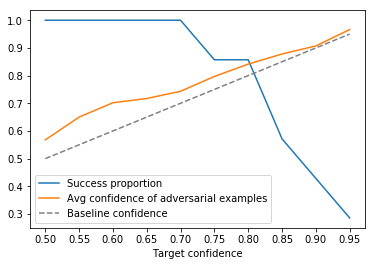

In [42]:
plot_confidence(results_graph_1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


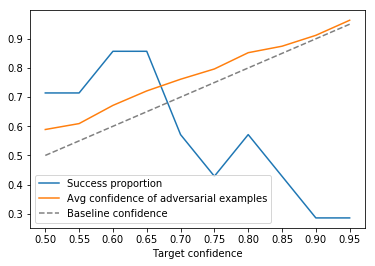

In [43]:
plot_confidence(results_graph_2)

Number of expanded nodes for graph 1 (strongly correlated with runtime)

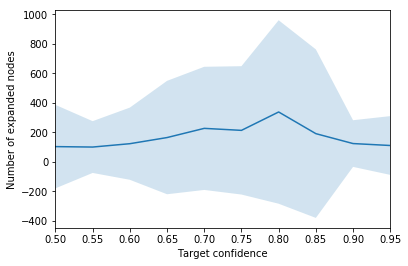

In [44]:
avg_expanded = pd.Series(
    [np.mean(result['nodes_expanded'][result['found']])
     for result in results_graph_1])
sigma_expanded = pd.Series(
    [np.std(result['nodes_expanded'][result['found']])
     for result in results_graph_1])

avg_runtime = pd.Series(
    [np.mean(result['runtime'][result['found']])
     for result in results_graph_1])

fig, ax = plt.subplots()
avg_expanded.plot(label='Number of expanded nodes', ax=ax)
ax.fill_between(range(len(confidence_levels)),
                avg_expanded - 2 * sigma_expanded,
                avg_expanded + 2 * sigma_expanded, alpha=.2)
ax.set_xticks(range(len(confidence_levels)))
ax.set_xticklabels(['%2.2f' % level for level in confidence_levels])
ax.set_xlim(0, len(confidence_levels) - 1)
ax.set_xlabel('Target confidence')
ax.set_ylabel('Number of expanded nodes')

# avg_runtime.plot(secondary_y=True, label='Avg runtime')
plt.show()